Computaton of group delay resulted from gain control as in Berry's model
by using a wave packet

adpated from:

https://dspillustrations.com/pages/posts/misc/group-delay-and-phase-delay-example.html


Sept 13, 2021 Created by CKC

In [17]:
import numpy as np
import math
import scipy as sp
from scipy import sparse
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time

In [18]:
from scipy.fftpack import fft, fftfreq
def FFT_quick(data, dt, center_data = False, center_faxis = True):
    if center_data:
        xft=fft(data-np.mean(data))
    else:
        xft=fft(data)
    xft_nor=xft/len(xft)
    freq=fftfreq(len(data), d=dt)

    if center_faxis:
        xft_nor = np.append( xft_nor[np.argmin(freq):],xft_nor[:np.argmin(freq)] )
        freq = np.append( freq[np.argmin(freq):], freq[:np.argmin(freq)] )
    return freq,xft_nor

In [19]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [20]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    # output[output<0] = 0
    return  output, gain

In [21]:
f0 = 0.1     # The resonant frequency of the circuit

Tot = 50/f0 # 100*period
dt = 0.001/f0
# Fs = 100

tAxis = np.arange(0, Tot, dt)
sinWave = np.sin(2*np.pi*f0*tAxis)
x = sinWave.copy()+1


In [22]:
T = 1/f0
GroupDelay_list = []
PhaseDelay_list = []
period_rate_list = np.linspace(0.5, 4.5, 50)
for delay in period_rate_list*T:
    delay = int(delay/dt+0.5)
    y = x.copy() # output signal
    gain =np.ones_like(x)

    B = 5
    for i in range(delay,len(x)):
        gain[i] = 1/(1+B*y[i-delay]**2)
        y[i]= gain[i]*x[i]

    # B = 80
    # tau = 10/f0
    # y, gain = AddGainControl(x, B, tau)
    # plt.plot(gain)

    fAxis,FT_x=FFT_quick(x[delay:], dt)
    fAxis,FT_y=FFT_quick(y[delay:], dt)

    H = FT_y/FT_x
    G = np.abs(H)
    Phi = np.angle(H)
    GroupDelay = -angular_gradient(Phi)/np.mean(np.diff(fAxis))
    PhaseDelay = -Phi/fAxis

    PhaseDelay_list.append(PhaseDelay[np.argmin(np.abs(fAxis-f0))])
    GroupDelay_list.append(GroupDelay[np.argmin(np.abs(fAxis-f0))])

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


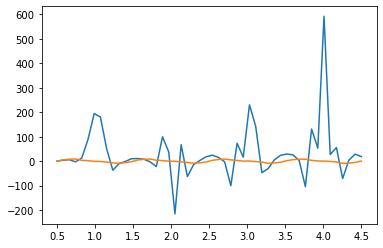

In [23]:
# plt.plot(np.linspace(0, 1, 50), GroupDelay_list)
plt.plot( period_rate_list, GroupDelay_list)
plt.plot( period_rate_list, PhaseDelay_list)

In [24]:
int(  (1.5*T)/dt+0.5)

1500